<a href="https://colab.research.google.com/github/mgupta325/Big-Data1/blob/master/Madhur_train_text_classifier_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Training a Text Classifier Using Embeddings

<table class="tfo-notebook-buttons" align="left">
          <td>
    <a target="_blank" href="https://ai.google.dev/examples/train_text_classifier_embeddings"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Generative AI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/examples/train_text_classifier_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/examples/train_text_classifier_embeddings.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

In this notebook, you'll learn to use the embeddings produced by the Gemini API to train a model that can classify different types of newsgroup posts based on the topic.

In this tutorial, you'll train a classifier to predict which class a newsgroup post belongs to.

## Prerequisites

You can run this quickstart in Google Colab.

To complete this quickstart on your own development environment, ensure that your envirmonement meets the following requirements:

-  Python 3.9+
-  An installation of `jupyter` to run the notebook.

## Setup

First, download and install the Gemini API Python library.

In [1]:
!pip install -U -q google.generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.9/146.9 kB 3.5 MB/s eta 0:00:00


In [2]:
import re
import tqdm
import keras
import numpy as np
import pandas as pd

import google.generativeai as genai
import google.ai.generativelanguage as glm

# Used to securely store your API key
from google.colab import userdata

import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics

### Grab an API Key

Before you can use the Gemini API, you must first obtain an API key. If you don't already have one, create a key with one click in Google AI Studio.

<a class="button button-primary" href="https://makersuite.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `API_KEY`.

Once you have the API key, pass it to the SDK. You can do this in two ways:

* Put the key in the `GOOGLE_API_KEY` environment variable (the SDK will automatically pick it up from there).
* Pass the key to `genai.configure(api_key=...)`

In [4]:
# Or use `os.getenv('API_KEY')` to fetch an environment variable.
API_KEY=userdata.get('API_KEY')

genai.configure(api_key=API_KEY)

Key Point: Next, you will choose a model. Any embedding model will work for this tutorial, but for real applications it's important to choose a specific model and stick with it. The outputs of different models are not compatible with each other.

In [5]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001


## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will be using the subsets of the training and test datasets. You will preprocess and organize the data into Pandas dataframes.

In [6]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is an example of what a data point from the training set looks like.

In [7]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Now you will begin preprocessing the data for this tutorial. Remove any sensitive information like names, email, or redundant parts of the text like `"From: "` and `"\nSubject: "`. Organize the information into a Pandas dataframe so it is more readable.

In [8]:
def preprocess_newsgroup_data(newsgroup_dataset):
  # Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
  newsgroup_dataset.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroup_dataset.data] # Remove email
  newsgroup_dataset.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroup_dataset.data] # Remove names
  newsgroup_dataset.data = [d.replace("From: ", "") for d in newsgroup_dataset.data] # Remove "From: "
  newsgroup_dataset.data = [d.replace("\nSubject: ", "") for d in newsgroup_dataset.data] # Remove "\nSubject: "

  # Cut off each text entry after 5,000 characters
  newsgroup_dataset.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroup_dataset.data]

  # Put data points into dataframe
  df_processed = pd.DataFrame(newsgroup_dataset.data, columns=['Text'])
  df_processed['Label'] = newsgroup_dataset.target
  # Match label to target name index
  df_processed['Class Name'] = ''
  for idx, row in df_processed.iterrows():
    df_processed.at[idx, 'Class Name'] = newsgroup_dataset.target_names[row['Label']]

  return df_processed

In [ ]:
# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


from matplotlib import pyplot as plt
_df_0['Label'].plot(kind='hist', bins=20, title='Label')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Class Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Label'].plot(kind='line', figsize=(8, 4), title='Label')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Class Name'].value_counts()
    for x_label, grp in _df_4.groupby('Text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Text')
_ = plt.ylabel('Class Name')

/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['Text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='Label', y='Text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['Class Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='Label', y='Class Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [10]:
def sample_data(df, num_samples, classes_to_keep):
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)

  df = df[df['Class Name'].str.contains(classes_to_keep)]

  # Reset the encoding of the labels after sampling and dropping certain categories
  df['Class Name'] = df['Class Name'].astype('category')
  df['Encoded Label'] = df['Class Name'].cat.codes

  return df

In [11]:
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = 'sci' # Class name should contain 'sci' in it to keep science categories
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [12]:
df_train.value_counts('Class Name')

Class Name
sci.crypt          100
sci.electronics    100
sci.med            100
sci.space          100
dtype: int64

In [13]:
df_test.value_counts('Class Name')

Class Name
sci.crypt          25
sci.electronics    25
sci.med            25
sci.space          25
dtype: int64

## Create the embeddings

In this section, you will see how to generate embeddings for a piece of text using the embeddings from the Gemini API. To learn more about embeddings, visit the [embeddings guide](https://googledevai.google.com/docs/embeddings_guide).

**NOTE**: Embeddings are computed one at a time, large sample sizes can take a long time!

### API changes to Embeddings embedding-001

For the new embeddings model, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [14]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLASSIFICATION.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="classification")
    return embedding['embedding']

  return embed_fn

def create_embeddings(model, df):
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

In [15]:
model = 'models/embedding-001'
df_train = create_embeddings(model, df_train)
df_test = create_embeddings(model, df_test)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
df_train.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,Re: Re-inventing Crypto Policy? An EFF State...,11,sci.crypt,0,"[-0.0035921352, -0.004268792, -0.064022586, -0..."
1101,"Re: Screw the people, crypto is for hard-core...",11,sci.crypt,0,"[0.021012936, -0.027079407, -0.079801776, -0.0..."
1102,SOURCE to Mactinosh PGP 2.2 in C available \n...,11,sci.crypt,0,"[0.024581196, -0.018440582, -0.07600636, -0.04..."
1103,Re: Secret algorithm [Re: Clipper Chip and cr...,11,sci.crypt,0,"[0.019449648, -0.017182656, -0.066710606, -0.0..."
1104,"Re: Once tapped, your code is no good any mor...",11,sci.crypt,0,"[-0.017460916, -0.04515207, -0.040998857, -0.0..."


## Build a simple classification model
Here you will define a simple model with one hidden layer and a single class probability output. The prediction will correspond to the probability of a piece of text being a particular class of news. When you build your model, Keras will automatically shuffle the data points.

In [17]:
def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
  inputs = x = keras.Input(input_size)
  x = layers.Dense(input_size, activation='relu')(x)
  x = layers.Dense(num_classes, activation='sigmoid')(x)
  return keras.Model(inputs=[inputs], outputs=x)

In [18]:
# Derive the embedding size from the first training element.
embedding_size = len(df_train['Embeddings'].iloc[0])

# Give your model a different name, as you have already used the variable name 'model'
classifier = build_classification_model(embedding_size, len(df_train['Class Name'].unique()))
classifier.summary()

classifier.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   optimizer = keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 768)               590592    
                                                                 
 dense_1 (Dense)             (None, 4)                 3076      
                                                                 
Total params: 593668 (2.26 MB)
Trainable params: 593668 (2.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
embedding_size

768

## Train the model to classify newsgroups

Finally, you can train a simple model. Use a small number of epochs to avoid overfitting. The first epoch takes much longer than the rest, because the embeddings need to be computed only once.

In [20]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = df_train['Encoded Label']
x_train = np.stack(df_train['Embeddings'])
y_val = df_test['Encoded Label']
x_val = np.stack(df_test['Embeddings'])

# Train the model for the desired number of epochs.
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = classifier.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         callbacks=[callback],
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 1s 18ms/step - loss: 1.1984 - accuracy: 0.7275 - val_loss: 0.9403 - val_accuracy: 0.9300
Epoch 2/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7109 - accuracy: 0.9675 - val_loss: 0.5645 - val_accuracy: 0.9500
Epoch 3/20
13/13 [==============================] - 0s 7ms/step - loss: 0.3721 - accuracy: 0.9800 - val_loss: 0.3345 - val_accuracy: 0.9500
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 0.1997 - accuracy: 0.9825 - val_loss: 0.2384 - val_accuracy: 0.9600
Epoch 5/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1233 - accuracy: 0.9925 - val_loss: 0.1988 - val_accuracy: 0.9600
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0862 - accuracy: 0.9925 - val_loss: 0.1747 - val_accuracy: 0.9600
Epoch 7/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0645 - accuracy: 0.9950 - val_loss: 0.1672 - val_accuracy: 0.9600
Epoch 8/20
13/13 [============

## Evaluate model performance

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset.

In [21]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9500


{'loss': 0.14109569787979126, 'accuracy': 0.949999988079071}

One way to evaluate your model performance is to visualize the classifier performance. Use `plot_history` to see the loss and accuracy trends over the epochs.

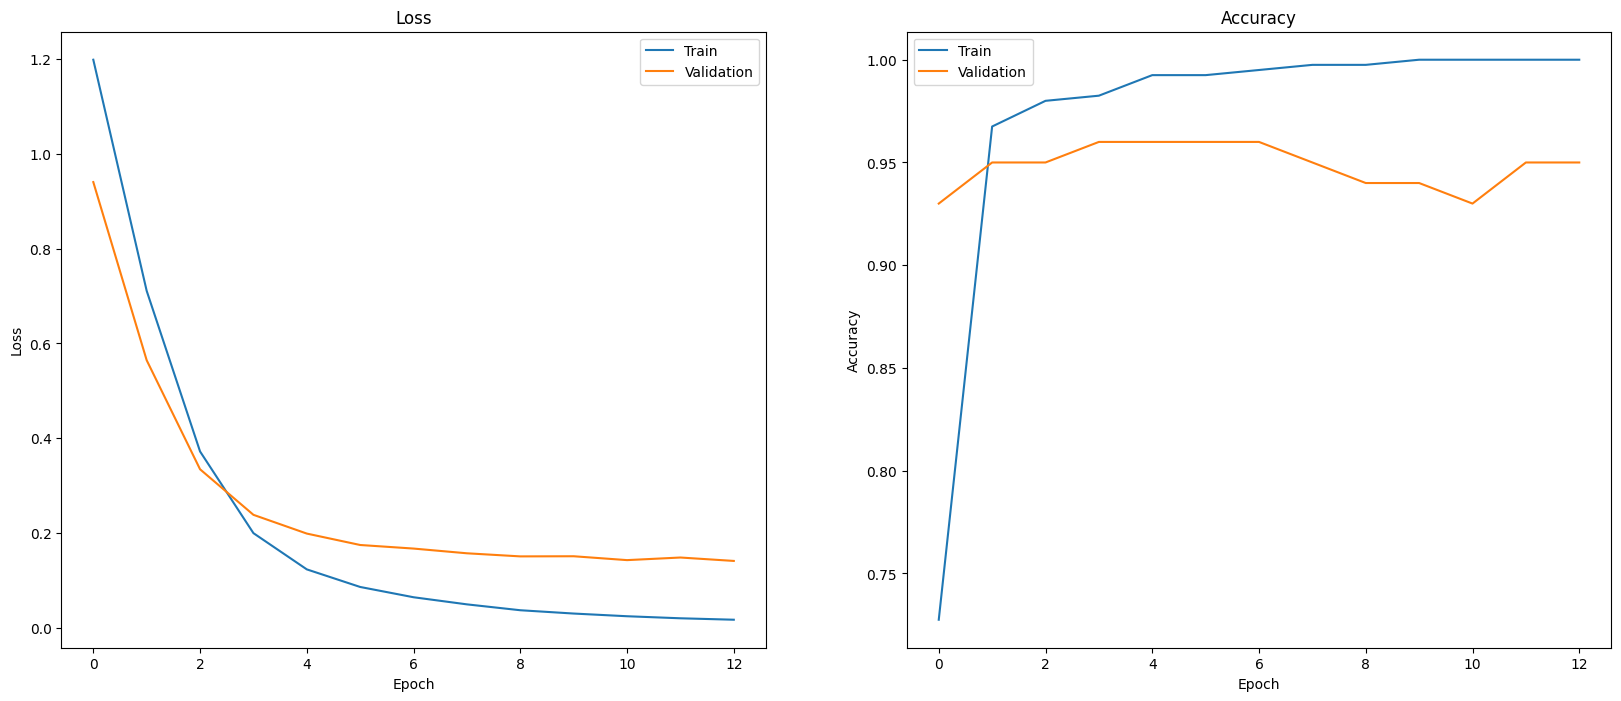

In [22]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

Another way to view model performance, beyond just measuring loss and accuracy is to use a confusion matrix. The confusion matrix allows you to assess the performance of the classification model beyond accuracy. You can see what misclassified points get classified as. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

Start by generating the predicted class for each example in the validation set using [`Model.predict()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict).

In [23]:
y_hat = classifier.predict(x=x_val)
y_hat = np.argmax(y_hat, axis=1)

4/4 [==============================] - 0s 3ms/step


In [24]:
labels_dict = dict(zip(df_test['Class Name'], df_test['Encoded Label']))
labels_dict

{'sci.crypt': 0, 'sci.electronics': 1, 'sci.med': 2, 'sci.space': 3}

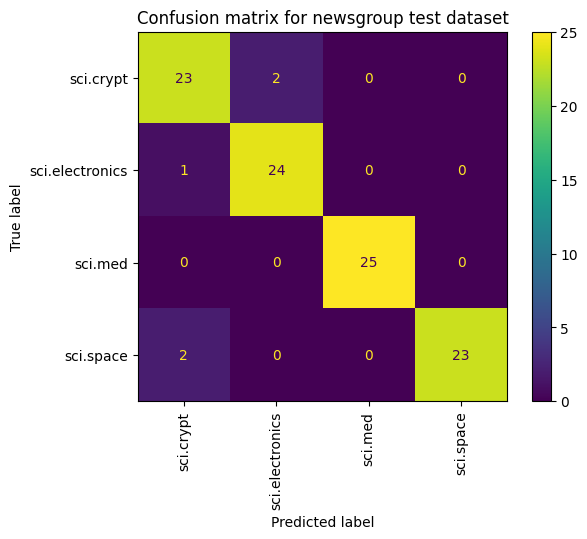

In [25]:
cm = skmetrics.confusion_matrix(y_val, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_dict.keys())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)

## Next steps

To learn more about how you can use the embeddings, check out the [examples](../examples?keywords=embed) available. To learn how to use other services in the Gemini API, visit the [Python quickstart](../tutorials/python_quickstart.ipynb).